In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
import numpy as np
import sys

Milestone 1

In [2]:
nc = 9
# milestone 3 works with 80, 20
nx = 300
ny = 300
w_i = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36]) #weights
c_ai = np.array([[0, 1, 0, -1, 0, 1, -1, -1, 1], #velocity field
                 [0, 0, 1, 0, -1, 1, 1, -1, -1]])

In [3]:
rho_ij = np.ones((nx, ny)) # density field
u_anm = np.zeros((2, nx, ny)) # velocity field

In [ ]:
f_inm = np.einsum('i,jk->ijk', w_i, np.ones((nx, ny))) # probability distribution

In [ ]:
rho = np.einsum('ijk->jk', f_inm) # density

Increasing density slightly test

In [ ]:
ar = np.zeros((nx, ny)) # Testing
ar[nx//2, ny//2] = 1

In [ ]:
ar = np.roll(ar, shift = c_ai.T[5], axis = (0, 1)) # Testing visualisation
fig, ax = plt.subplots()
ax.imshow(ar)
plt.show()

In [ ]:
f_inm[:,nx//2, ny//2] *= 1.01 #increase the density slightly

In [ ]:
rho = np.einsum('inm->nm', f_inm)

for i in np.arange(1, 9): #streaming function
    f_inm[i] = np.roll(f_inm[i], shift = c_ai.T[i], axis = (0, 1))

fig, ax = plt.subplots()
ax.imshow(rho)
plt.show()

Milestone 2

In [ ]:
rho_ij[nx//2, ny//2] *= 1.01

In [ ]:
omega = 1.3

Milestone 3

Step 1 initial distribution

In [ ]:
L = nx
x = np.arange(0, nx)
y = np.arange(0, ny)
X, Y = np.meshgrid(x, y)

In [ ]:
omega = 1.3
eps = 0.01
rho_0 = 0.5

In [ ]:
u_anm = np.zeros((2, nx, ny))

In [ ]:
rhox = np.zeros((nx, ny))
rhoy = rho_0 + (eps * np.sin(2*(np.pi*X)/L))

In [ ]:
rho_ij = np.stack((rhox, rhoy), axis = 0)

In [ ]:
rho_ij = np.einsum('ijk->jk', rho_ij) # density

Step 2 initial distribution

In [4]:
L = ny
x = np.arange(0, nx)
y = np.arange(0, ny)
X, Y = np.meshgrid(x, y)

In [5]:
omega = 1.3
eps = 0.01

In [6]:
ux = eps * np.sin(2*np.pi*Y/L)
uy = np.zeros((nx, ny))

In [7]:
uy = eps * np.sin(2*np.pi*x/nx)
u_anm = np.array([np.zeros((nx, ny)), np.tile(uy[:, np.newaxis], (1, ny))])
rho_ij = np.ones((nx, ny)) # density field

Calculate equilibrium function

In [8]:
def calculate_eq_dist(rho_nm, u_anm, c_ai, w_i):
    u_anm_x_u_anm = np.einsum('anm, anm->nm', u_anm, u_anm)
    c_ai_x_u_anm = np.einsum('ai,anm->inm', c_ai, u_anm)
    cu_sq = c_ai_x_u_anm**2
    wrho_inm = np.einsum('i,nm->inm', w_i, rho_nm)
    f_eq = wrho_inm * (1 + 3 * c_ai_x_u_anm + 4.5 * cu_sq - 1.5 * u_anm_x_u_anm)
    return f_eq

Calculate collision and streaming function

In [9]:
def collision(f_inm, c_ai, w_i, omega):
    rho_nm = np.einsum('inm->nm', f_inm)                   # calculate density
    u_anm = np.einsum('ia,inm->anm', c_ai.T, f_inm) / rho_nm # calculate average velocity
    f_eq = calculate_eq_dist(rho_nm, u_anm, c_ai, w_i)
    f_inm += ((f_eq - f_inm) * omega)
    return f_inm, u_anm, rho_nm

In [10]:
def streaming_operator(f_inm, c_ai):
    rho_nm = np.einsum('inm->nm', f_inm)
    for i in np.arange(1, 9): #streaming function
        f_inm[i] = np.roll(f_inm[i], shift = c_ai.T[i], axis = (0, 1))
    return f_inm, rho_nm

density collision and streaming

In [ ]:
f_inm = calculate_eq_dist(rho_ij, u_anm, c_ai, w_i)

In [ ]:
num_steps = 8000

In [ ]:
d_array = np.empty((8, nx))
for i in range(num_steps):
    f_inm, rho_ij = streaming_operator(f_inm, c_ai)
    f_inm, u_anm, rho_ij = collision(f_inm, c_ai, w_i, omega)
    if i%1000 == 0:
        d_array[i//1000] = rho_ij[0, :]

In [ ]:
fig, ax = plt.subplots()
for i in range(8):
    plt.plot(d_array[i])
ax.set_title("Density in y direction over time")
ax.set_xlabel("y")
ax.set_ylabel("density")
plt.show()

In [ ]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(15, 7), sharey=True)
fig.subplots_adjust(hspace=0.3)
fig.suptitle('Density distribution in y direction over time')
for i, ax in enumerate(axs.flat):
    ax.plot(d_array[i])
    ax.set_title(f"{i*1000} timestep")
    ax.set_xlabel('y')
    ax.set_ylabel('density')
plt.show()

velocity collision and streaming

In [11]:
f_inm = calculate_eq_dist(rho_ij, u_anm, c_ai, w_i)

In [12]:
num_steps = 16000

In [13]:
# amplitude
a_array = np.array([])

In [14]:
vel_array = np.zeros((8,ny))

In [15]:
v_array = np.empty((num_steps, nx))
for i in range(num_steps):
    f_inm, rho_ij = streaming_operator(f_inm, c_ai)
    f_inm, u_anm, rho_ij = collision(f_inm, c_ai, w_i, omega)
    if i%2000 == 0:
        vel_array[i//2000] = u_anm[1,:,0]

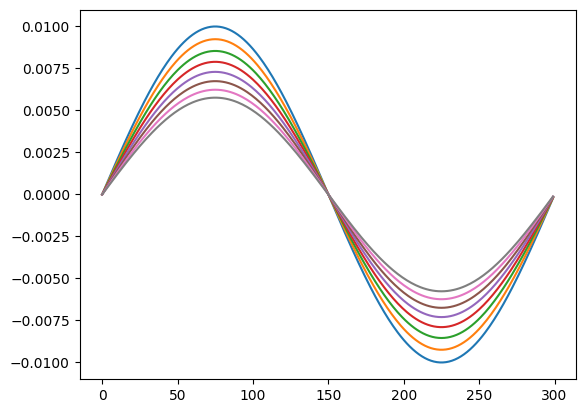

In [16]:
for i in range(8):
    plt.plot(vel_array[i])
plt.show()

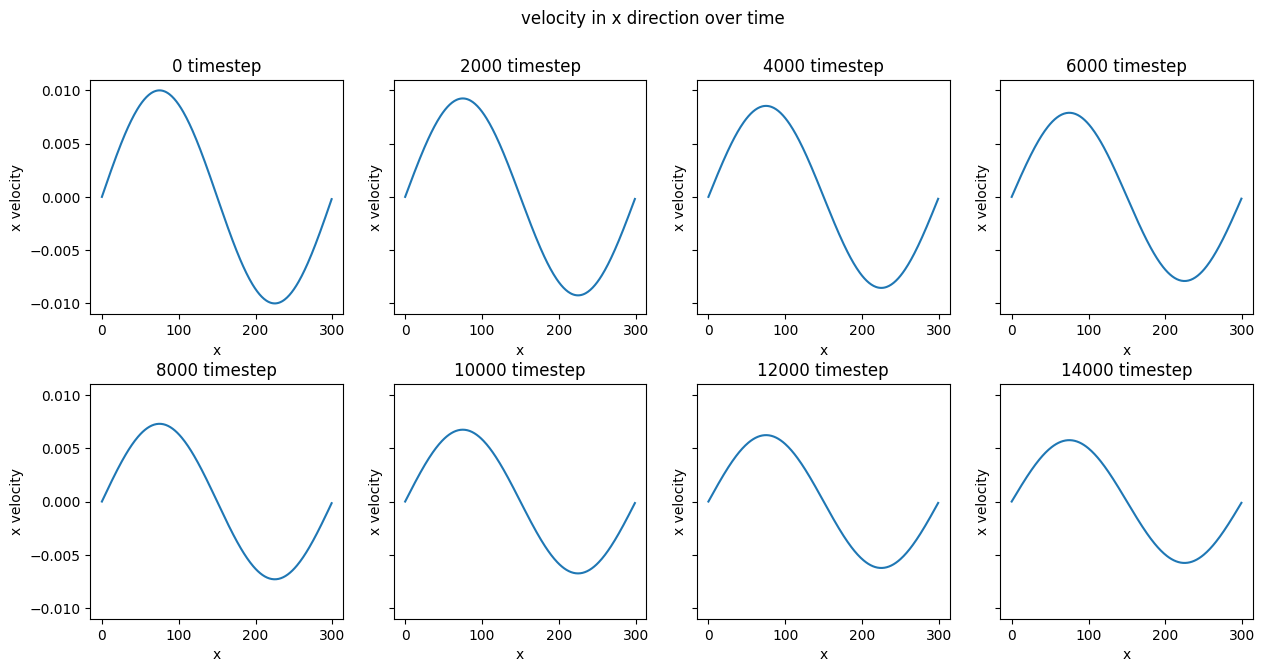

In [18]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(15, 7), sharey=True)
fig.subplots_adjust(hspace=0.3)
fig.suptitle('velocity in x direction over time')
for i, ax in enumerate(axs.flat):
    ax.plot(vel_array[i])
    ax.set_title(f"{i*2000} timestep")
    ax.set_xlabel('x')
    ax.set_ylabel('x velocity')
plt.show()

Case 1 perturbation decay

In [ ]:
num_steps = 8000
omega = 1.3
eps = 0.01
rho_0 = 0.5

L = nx
x = np.arange(0, nx)
y = np.arange(0, ny)
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots()

for omega in np.arange(0.01, 1.9, 0.1):
    theoretical_pertub_array = np.array([])
    densities_amp = np.array([])
    d_array = np.empty((num_steps, nx))
    print(omega)

    u_anm = np.zeros((2, nx, ny))
    rhox = np.zeros((nx, ny))
    rhoy = rho_0 + (eps * np.sin(2*(np.pi*X)/L))
    rho_ij = np.stack((rhox, rhoy), axis = 0)
    rho_ij = np.einsum('ijk->jk', rho_ij)

    f_inm = calculate_eq_dist(rho_ij, u_anm, c_ai, w_i)
    for i in range(num_steps):
        f_inm, rho_ij = streaming_operator(f_inm, c_ai)
        f_inm, u_anm, rho_ij = collision(f_inm, c_ai, w_i, omega)
        d_array[i] = rho_ij[0, :]
    amp = d_array[:,nx//4] / eps
    ax.plot(np.arange(0,8000), amp)
    ax.set_xlabel("time t")
    ax.set_ylabel("rho at x = 25 / epsilon")

Case 2 perturbation decay

In [ ]:
def theoretical_perturbation(t, L, omega):
    viscosity = 1/3 * (1/omega - 1/2)
    k = 2 * np.pi / L
    return np.exp(-viscosity * k**2 * t)


In [ ]:
num_steps = 8000
eps = 0.01

x = np.arange(0, nx)
y = np.arange(0, ny)

fig, ax = plt.subplots()

for omega in np.arange(0.01, 1.9, 0.1):
    theoretical_pertub_array = np.array([])
    velocities_amp = np.array([])
    v_array = np.empty((num_steps, nx))
    print(omega)
    uy = eps * np.sin(2*np.pi*x/nx)
    u_anm = np.array([np.zeros((nx, ny)), np.tile(uy[:, np.newaxis], (1, ny))])
    rho_ij = np.ones((nx, ny)) # density field

    f_inm = calculate_eq_dist(rho_ij, u_anm, c_ai, w_i)
    for i in range(num_steps):
        f_inm, rho_ij = streaming_operator(f_inm, c_ai)
        f_inm, u_anm, rho_ij = collision(f_inm, c_ai, w_i, omega)
        v_array[i] = u_anm[1, :, 0]

    amp = v_array[:,nx//4] / eps
    color = next(ax._get_lines.prop_cycler)['color']
    ax.plot(np.arange(0,8000), amp, label=f"omega={omega:.2f}", color=color) # numerical decay
    ax.plot(np.arange(0,8000), theoretical_perturbation(np.arange(0,8000), nx, omega), linestyle='--', color=color, linewidth=3)
ax.legend(ncol=3)
ax.set_xlabel("time t")
ax.set_ylabel("ux(t) at y = 25 / epsilon")

Case 1 viscosity density

In [ ]:
eps = 0.01
num_steps = 8000
v_by_omega = np.array([])

for omega in np.arange(0.01, 1.9, 0.1):
    u_anm = np.zeros((2, nx, ny))

    rhox = np.zeros((nx, ny))
    rhoy = rho_0 + (eps * np.sin(2*(np.pi*X)/L))
    rho_ij = np.stack((rhox, rhoy), axis = 0)
    rho_ij = np.einsum('ijk->jk', rho_ij)

    f_inm = calculate_eq_dist(rho_ij, u_anm, c_ai, w_i)
    d_array = np.empty((num_steps, nx))
    for i in range(num_steps):
        f_inm, rho_ij = streaming_operator(f_inm, c_ai)
        f_inm, u_anm, rho_ij = collision(f_inm, c_ai, w_i, omega)
        d_array[i] = rho_ij[0, :]

    amp = d_array[:,nx//4]
    viscosity = (np.log(amp[0]) - np.log(amp[3000])) / (((2 * np.pi / nx)**2) * 3000)
    v_by_omega = np.append(v_by_omega, viscosity)


Case 2 Viscosity velocity

In [ ]:
def analytical_pred(omega):
    return 1/3 * (1/omega - 1/2)

In [ ]:
plt.plot(analytical_pred(np.arange(0.01, 1.9, 0.05)))
plt.show()

In [ ]:
eps = 0.01

x = np.arange(0, nx)
y = np.arange(0, ny)

num_steps = 8000
v_by_omega = np.array([])
rho_ij = np.ones((nx, ny))
velocities_amp = np.array([])

for omega in np.arange(0.01, 1.9, 0.1):
    uy = eps * np.sin(2*np.pi*x/nx)
    u_anm = np.array([np.zeros((nx, ny)), np.tile(uy[:, np.newaxis], (1, ny))])
    rho_ij = np.ones((nx, ny)) # density field

    f_inm = calculate_eq_dist(rho_ij, u_anm, c_ai, w_i)
    v_array = np.empty((num_steps, nx))
    for i in range(num_steps):
        f_inm, rho_ij = streaming_operator(f_inm, c_ai)
        f_inm, u_anm, rho_ij = collision(f_inm, c_ai, w_i, omega)
        v_array[i] = u_anm[1, :, 0]

    amp = v_array[:,nx//4]
    viscosity = (np.log(amp[0]) - np.log(amp[3000])) / (((2 * np.pi / nx)**2) * 3000)
    v_by_omega = np.append(v_by_omega, viscosity)


In [ ]:
x = np.linspace(0.01, 1.9)
fig, ax = plt.subplots()
blue = mpatches.Patch(color='blue', label='Theoretical')
orange = mpatches.Patch(color='orange', label='Experimental')
ax.legend(handles=[blue, orange])
plt.plot(x, analytical_pred(x))
plt.plot(np.arange(0.01, 1.9, 0.1), v_by_omega)
plt.xlabel('\u03C9')
plt.ylabel('kinematic viscosity v')
plt.title('Analytical comparison with experimental viscosity prediction')
plt.show()

Milestone 4

In [ ]:
c_ai = np.array([[0, 0, -1, 0, 1, -1, -1, 1, 1],
                [0, 1, 0, -1, 0, 1, -1, -1, 1]])

In [ ]:
def boundary_con_south(new_f_inm, f_inm):

    opposite = np.array([0, 3, 4, 1, 2, 7, 8, 5, 6])
    for i in np.array([4, 7, 8]):
        new_f_inm[opposite[i], -1, :] = f_inm[i, -1, :]
    return new_f_inm

In [ ]:
def moving_wall(new_f_inm, f_inm, u_anm, c_ai):
    opposite = np.array([0, 3, 4, 1, 2, 7, 8, 5, 6])
    u = [0, 0.1]
    rho_nm = np.einsum('inm->nm', f_inm)
    rho_mean = np.mean(rho_nm)
    sound_speed_squared = (1/np.sqrt(3))**2

    for i in np.array([2, 5, 6]):
        new_f_inm[opposite[i], 0, :] = f_inm[i, 0, :] - 2 * w_i[i] * rho_mean * (c_ai[:, i] @ u) / sound_speed_squared


    return new_f_inm

In [ ]:
rho_ij = np.ones((nx, ny)) # density field
u_anm = np.zeros((2, nx, ny)) # velocity field

In [ ]:
def streaming_operator(f_inm, c_ai):
    new_f_inm = np.empty_like(f_inm)
    np.copyto(new_f_inm, f_inm)
    for i in np.arange(1, 9): #streaming function
        new_f_inm[i] = np.roll(new_f_inm[i], shift = c_ai.T[i], axis = (0, 1))

    return new_f_inm, f_inm

In [ ]:
omega = 1.3
num_steps = 20000
f_inm = calculate_eq_dist(rho_ij, u_anm, c_ai, w_i)
vel_field = np.empty((num_steps, nx, ny))
for i in range(num_steps):
    f_inm, u_anm, rho_ij = collision(f_inm, c_ai, w_i, omega)
    new_f_inm, f_inm = streaming_operator(f_inm, c_ai)
    f_inm = boundary_con_south(new_f_inm, f_inm)
    f_inm = moving_wall(new_f_inm, f_inm, u_anm, c_ai)
    vel_field[i] = u_anm[1, :, :]


In [ ]:
fig, ax = plt.subplots()
cmap = mpl.cm.cool(np.linspace(0,1,num_steps))
for t in np.arange(num_steps):
    if t%1000==0:
        y = np.arange(0,100)
        x = vel_field[t, :, nx//2]
        ax.plot(x,y, label=f"timestep={t}", color=cmap[t])
ax.invert_yaxis()
plt.xlabel('velocity u(y)')
plt.ylabel('y')
plt.title('Couette Flow velocity field')
plt.legend(ncol=2)
plt.show()

Milestone 5

In [ ]:
def boundary_con_south(new_f_inm, f_inm):

    opposite = np.array([0, 3, 4, 1, 2, 7, 8, 5, 6])
    for i in np.array([4, 7, 8]):
        #f_inm[opposite[i], -1, :] = f_inm[i, -1, :] # -2 is wet node -1 is dry node
        new_f_inm[opposite[i], -1, :] = f_inm[i, -1, :] # -2 is wet node -1 is dry node
    #f_inm[:, -1, :] = 1 # -2 is wet node -1 is dry node
    return new_f_inm

In [ ]:
def calculate_eq_dist(rho_nm, u_anm, c_ai, w_i):
    u_anm_x_u_anm = np.einsum('anm, anm->nm', u_anm, u_anm)
    c_ai_x_u_anm = np.einsum('ai,anm->inm', c_ai, u_anm)
    cu_sq = c_ai_x_u_anm**2
    wrho_inm = np.einsum('i,nm->inm', w_i, rho_nm)
    f_eq = wrho_inm * (1 + 3 * c_ai_x_u_anm + 4.5 * cu_sq - 1.5 * u_anm_x_u_anm)
    return f_eq

In [ ]:
def streaming_operator(f_inm, c_ai):
    new_f_inm = np.empty_like(f_inm)
    np.copyto(new_f_inm, f_inm)
    for i in np.arange(1, 9): #streaming function
        new_f_inm[i] = np.roll(new_f_inm[i], shift = c_ai.T[i], axis = (0, 1))

    return new_f_inm, f_inm

In [ ]:
def calculate_eq_dist_pressure(rho, u_an, c_ai, w_i):

    u_an_x_u_an = np.einsum('an,an->n', u_an, u_an)
    c_ai_x_u_an = np.einsum('ai,an->in', c_ai, u_an)
    cu_sq = c_ai_x_u_an**2
    wrho_inm = np.einsum('i,n->in', w_i, rho)
    f_eq = wrho_inm * (1 + 3 * c_ai_x_u_an + 4.5 * cu_sq - 1.5 * u_an_x_u_an)
    return f_eq

In [ ]:
f_inm = np.einsum('i,jk->ijk', w_i, np.ones((nx, ny))) # probability distribution

In [ ]:
rho_ij = np.ones((nx, ny)) # density field
u_anm = np.zeros((2, nx, ny)) # velocity field

In [ ]:
d_inlet = 1.005
d_outlet = 0.995

In [ ]:
def pressure_variation(f_inm, rho_nm, u_anm, c_ai, w_i, d_inlet, d_outlet):
    # Inlet boundary condition
    f_eq_in = calculate_eq_dist_pressure(d_inlet * np.ones(nx), u_anm[:, :, -2], c_ai, w_i)
    f_neq_in = f_inm[:, :, -2] - calculate_eq_dist_pressure(rho_nm[:, -2], u_anm[:, :, -2], c_ai, w_i)
    for i in range(0, 9):
        f_inm[i, :, 0] = np.add(f_eq_in[i], f_neq_in[i])
    # Outlet boundary condition
    # equilibrium for outlet
    f_eq_out = calculate_eq_dist_pressure(d_outlet * np.ones(nx), u_anm[:, :, 1], c_ai, w_i)
    # non equilibrium for outlet
    f_neq_out = f_inm[:, :, 1] - calculate_eq_dist_pressure(rho_nm[:, 1], u_anm[:, :, 1], c_ai, w_i)
    for i in range(0, 9):
        f_inm[i, :, -1] = np.add(f_eq_out[i], f_neq_out[i])
    return f_inm

In [ ]:
def boundary_con_north(new_f_inm, f_inm):
    opposite = np.array([0, 3, 4, 1, 2, 7, 8, 5, 6])
    for i in np.array([2, 5, 6]):
        new_f_inm[opposite[i], -1, :] = f_inm[i, -1, :] # -2 is wet node -1 is dry node
    return new_f_inm

In [ ]:
def collision(f_inm, c_ai, w_i, omega):
    rho_nm = np.einsum('inm->nm', f_inm)                   # calculate density
    u_anm = np.einsum('ia,inm->anm', c_ai.T, f_inm) / rho_nm # calculate average velocity
    f_eq = calculate_eq_dist(rho_nm, u_anm, c_ai, w_i)
    f_inm += ((f_eq - f_inm) * omega)
    return f_inm, u_anm, rho_nm

In [ ]:
num_steps = 20000
omega = 1.3

In [ ]:
f_inm = calculate_eq_dist(rho_ij, u_anm, c_ai, w_i)
vel_field = np.empty((num_steps, 2, nx, ny))
for i in range(num_steps):
    f_inm, u_anm, rho_ij = collision(f_inm, c_ai, w_i, omega)

    f_inm = pressure_variation(f_inm, rho_ij, u_anm, c_ai, w_i, d_inlet, d_outlet)
    new_f_inm, f_inm = streaming_operator(f_inm, c_ai)
    new_f_inm = boundary_con_south(new_f_inm, f_inm)
    f_inm = boundary_con_north(new_f_inm, f_inm)
    vel_field[i] = u_anm

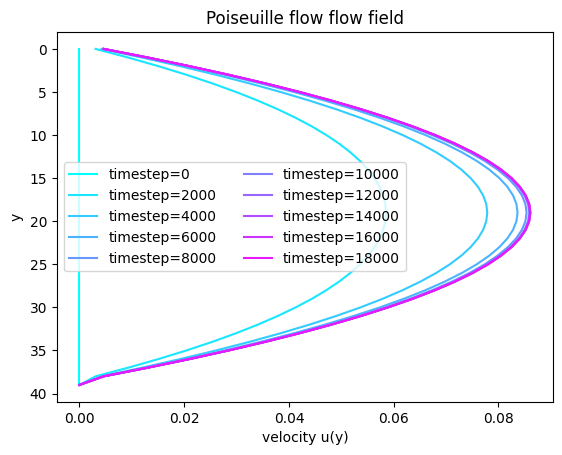

In [ ]:
fig, ax = plt.subplots()
cmap = mpl.cm.cool(np.linspace(0,1,num_steps))
for t in np.arange(num_steps):
    if t % 2000 == 0:
        x = vel_field[t, 1, :, 0]
        y = np.arange(0,40)
        ax.plot(x, y, label=f"timestep={t}", color=cmap[t])
plt.xlabel('velocity u(y)')
plt.ylabel('y')
plt.title('Poiseuille flow flow field')
plt.legend(ncol=2)
ax.invert_yaxis()
plt.show()

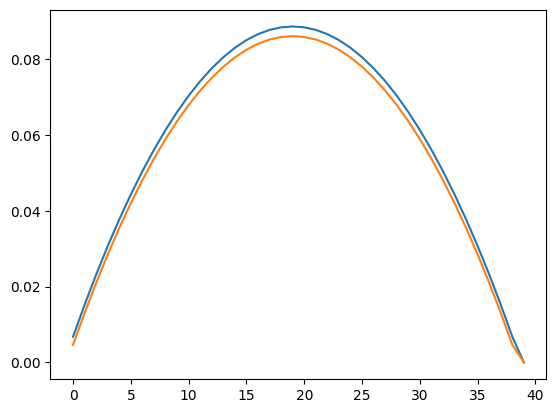

In [ ]:
fig, ax = plt.subplots()
x1 = vel_field[-1, 1, :, ny//2]
ax.plot(x1)
x2 = vel_field[-1, 1, :, 0]
ax.plot(x2)
plt.show()

In [ ]:
def analytical_poiseuille(y):
    # pressure derivative
    grad_p = 1/3 * (d_outlet - d_inlet)/ny
    # dynamic viscosity
    kinematic = 1/3 * (1/omega - 1/2)
    density = np.mean(rho_ij[:, 0])
    viscosity = kinematic * density
    u = (0.5 / viscosity) * grad_p * y * (y - nx)
    return u

(40,)
40


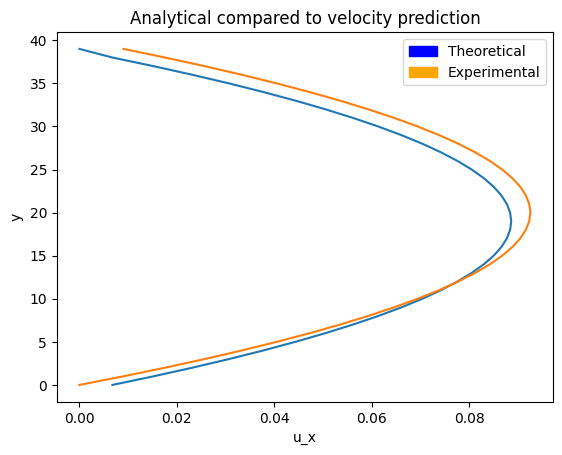

In [ ]:
y = np.arange(0, nx)
fig, ax = plt.subplots()
blue = mpatches.Patch(color='blue', label='Theoretical')
orange = mpatches.Patch(color='orange', label='Experimental')
ax.legend(handles=[blue, orange])
plt.plot(vel_field[-1, 1, :, ny//2], y)
plt.plot(analytical_poiseuille(y), y)
plt.xlabel('u_x')
plt.ylabel('y')
plt.title('Analytical compared to velocity prediction')
plt.show()

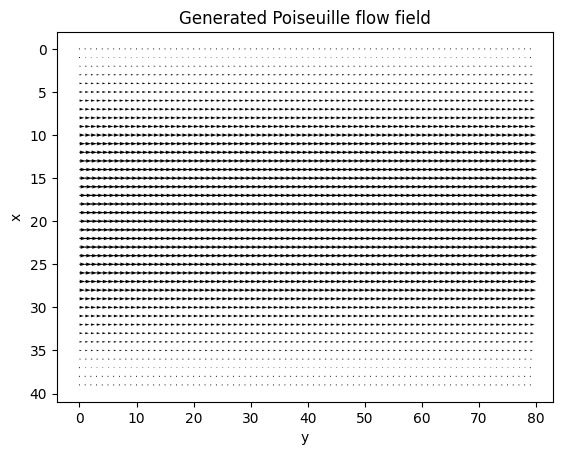

In [ ]:
fig, ax = plt.subplots()
x, y = np.meshgrid(np.arange(0, 80),
                   np.arange(0, 40))
u = vel_field[-1, 1, :, :]
v = vel_field[-1, 0, :, :]
plt.xlabel('y')
plt.ylabel('x')
ax.quiver(x, y, u, v)
ax.invert_yaxis()
plt.title('Generated Poiseuille flow field')
plt.show()

In [ ]:
np.arange(50, 0, -1)

In [ ]:
velocity_areas = np.array([np.trapz(vel_field[-1, 1, :, i], np.arange(0, nx)) for i in np.arange(1, ny - 1)])

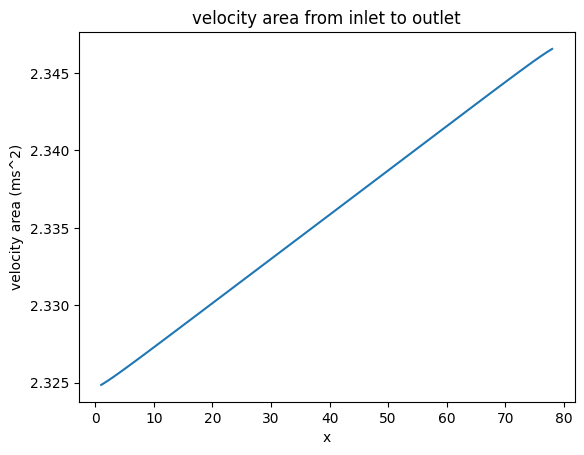

% increase in velocity area is 0.9342429467875741


In [ ]:
plt.plot(np.arange(1, ny - 1), velocity_areas)
plt.xlabel('x')
plt.ylabel('velocity area (ms^2)')
plt.title("velocity area from inlet to outlet")
plt.show()
last = velocity_areas[-1]
first = velocity_areas[0]
print(f"% increase in velocity area is {(last-first)/first * 100}")

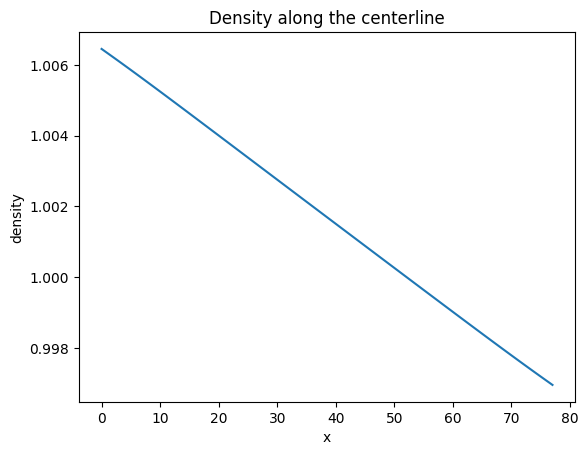

In [ ]:
plt.plot(rho_ij[nx//2, 1:-1])
plt.xlabel('x')
plt.ylabel('density')
plt.title('Density along the centerline')
plt.show()

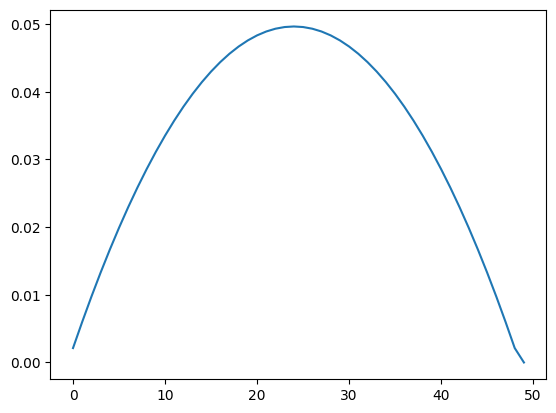

In [ ]:
plt.plot(u_anm[1, :, 0])

Milestone 6

In [ ]:
nc = 9
nx = 300
ny = 300

In [ ]:
w_i = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36]) #weights
#c_ai = np.array([[0, 1, 0, -1, 0, 1, -1, -1, 1], #velocity field
#                 [0, 0, 1, 0, -1, 1, 1, -1, -1]])
c_ai = np.array([[0, 0, -1, 0, 1, -1, -1, 1, 1],
                [0, 1, 0, -1, 0, 1, -1, -1, 1]])
wall_velocity = 0.3

In [ ]:
rho_ij = np.ones((nx, ny)) # density field
u_anm = np.zeros((2, nx, ny)) # velocity field

In [ ]:
omega = 1.3
kinematic = 1/3 * (1/omega - 1/2)
density = np.mean(rho_ij[:, 0])
viscosity = kinematic * density
Re = ny * wall_velocity / viscosity

1002.8571428571431


In [ ]:
def boundary_con_south(new_f_inm, f_inm):

    opposite = np.array([0, 3, 4, 1, 2, 7, 8, 5, 6])
    for i in np.array([4, 7, 8]):
        new_f_inm[opposite[i], -1, :] = f_inm[i, -1, :] # -2 is wet node -1 is dry node
    return new_f_inm

In [ ]:
def boundary_con_east(new_f_inm, f_inm):

    opposite = np.array([0, 3, 4, 1, 2, 7, 8, 5, 6])
    for i in np.array([1, 5, 8]):
        new_f_inm[opposite[i], :, -1] = f_inm[i, :, -1]
    return new_f_inm

In [ ]:
def boundary_con_west(new_f_inm, f_inm):

    opposite = np.array([0, 3, 4, 1, 2, 7, 8, 5, 6])
    for i in np.array([3, 6, 7]):
        new_f_inm[opposite[i], :, 0] = f_inm[i, :, 0]
    return new_f_inm

In [ ]:
def boundary(new_f_inm, f_inm):
    opposite = np.array([0, 3, 4, 1, 2, 7, 8, 5, 6])
    for i in np.array([4, 7, 8]):
        new_f_inm[opposite[i], -1, :] = f_inm[i, -1, :] # -2 is wet node -1 is dry node
    for i in np.array([1, 5, 8]):
        new_f_inm[opposite[i], :, -1] = f_inm[i, :, -1]
    for i in np.array([3, 6, 7]):
        new_f_inm[opposite[i], :, 0] = f_inm[i, :, 0]
    return new_f_inm

In [ ]:
def moving_wall(new_f_inm, f_inm, u_anm, c_ai, wall_velocity):
    opposite = np.array([0, 3, 4, 1, 2, 7, 8, 5, 6])
    u = [0, wall_velocity]
    rho_nm = np.einsum('inm->nm', f_inm)
    rho_mean = np.mean(rho_nm)
    sound_speed_squared = (1/np.sqrt(3))**2
    for i in np.array([2, 5, 6]):
        new_f_inm[opposite[i], 0, :] = f_inm[i, 0, :] - 2 * w_i[i] * rho_mean * (c_ai[:, i] @ u) / sound_speed_squared


    return new_f_inm

In [ ]:
def calculate_eq_dist(rho_nm, u_anm, c_ai, w_i):
    u_anm_x_u_anm = np.einsum('anm, anm->nm', u_anm, u_anm)
    c_ai_x_u_anm = np.einsum('ai,anm->inm', c_ai, u_anm)
    cu_sq = c_ai_x_u_anm**2
    wrho_inm = np.einsum('i,nm->inm', w_i, rho_nm)
    f_eq = wrho_inm * (1 + 3 * c_ai_x_u_anm + 4.5 * cu_sq - 1.5 * u_anm_x_u_anm)
    return f_eq

In [ ]:
def collision(f_inm, c_ai, w_i, omega):
    rho_nm = np.einsum('inm->nm', f_inm)                   # calculate density
    u_anm = np.einsum('ia,inm->anm', c_ai.T, f_inm) / rho_nm # calculate average velocity
    f_eq = calculate_eq_dist(rho_nm, u_anm, c_ai, w_i)
    f_inm += ((f_eq - f_inm) * omega)
    return f_inm, u_anm, rho_nm

In [ ]:
def streaming_operator(f_inm, c_ai):
    new_f_inm = np.empty_like(f_inm)
    np.copyto(new_f_inm, f_inm)
    for i in np.arange(1, 9): #streaming function
        new_f_inm[i] = np.roll(new_f_inm[i], shift = c_ai.T[i], axis = (0, 1))

    return new_f_inm, f_inm

In [ ]:
num_steps = 19000
vel_field = np.empty((7, 2, nx, ny))
f_inm = calculate_eq_dist(rho_ij, u_anm, c_ai, w_i)
for i in range(num_steps):
    print(i)
    f_inm, u_anm, rho_ij = collision(f_inm, c_ai, w_i, omega)
    new_f_inm, f_inm = streaming_operator(f_inm, c_ai)
    new_f_inm = boundary(new_f_inm, f_inm)
    f_inm = moving_wall(new_f_inm, f_inm, u_anm, c_ai, wall_velocity)
    if i%3000==0:
      vel_field[i//3000] = u_anm

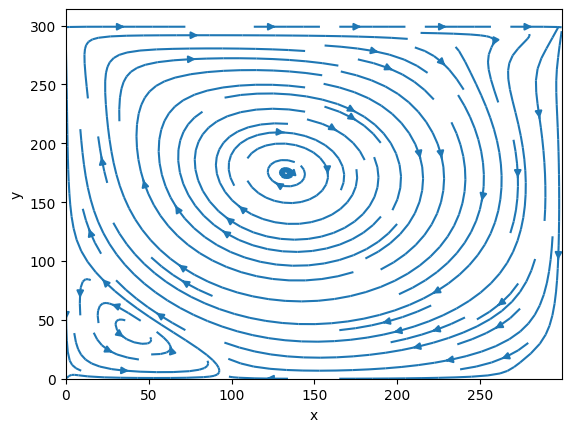

In [ ]:
x = np.arange(nx)
y = np.arange(ny)
u = np.flip(vel_field[-1, 1])
v = np.flip(vel_field[-1, 0])
norm = plt.Normalize(0, wall_velocity)
plt.xlabel('x')
plt.ylabel('y')
plt.streamplot(x, y, u, v, norm=norm)
plt.show()

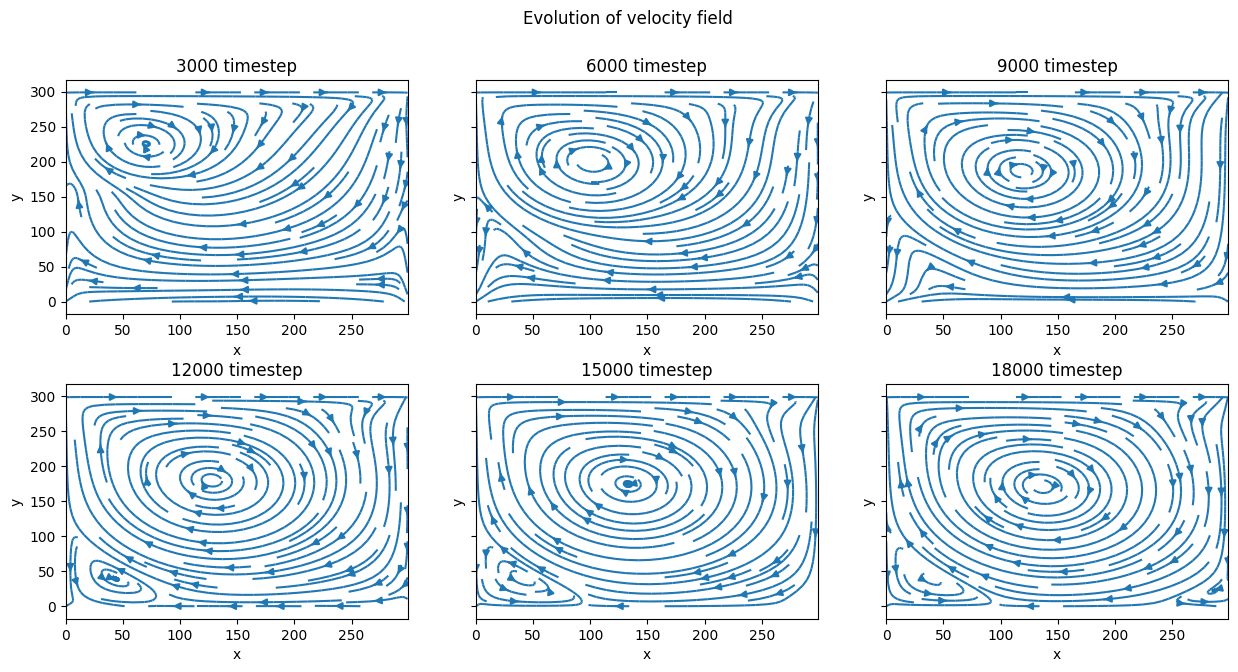

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 7), sharey=True)
fig.subplots_adjust(hspace=0.3)
fig.suptitle('Evolution of velocity field')
x = np.arange(nx)
y = np.arange(ny)
norm = plt.Normalize(0, wall_velocity)
for i, ax in enumerate(axs.flat)t:
    u = np.flip(vel_field[i+1, 1])
    v = np.flip(vel_field[i+1, 0])
    ax.streamplot(x, y, u, v, norm=norm)
    ax.set_title(f"{(i+1)*3000} timestep")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
plt.show()